# Checkpoint 1

**Due: Friday, 16 October, 2020 at 5:00pm BST**

### Read This First
1. Use the constants provided in the cell below. Do not use your own constants.

2. Put the code that produces the output for a given task in the cell indicated. You are welcome to add as many cells as you like for imports, function definitions, variables, etc. **Additional cells need to be in the proper order such that your code runs correctly the first time through.**

3. **IMPORTANT!** Before submitting your notebook, clear the output by clicking *Restart & Clear Output* from the *Kernel* menu. If you do not do this, the file size of your notebook will be very large.

## Libraries and Constants
Custom imports and constants should be added to a new cell.

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline
import numpy as np
from scipy import integrate, optimize
import time

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16

# Gravitational constant
gg     = 6.67408e-11 # m^3 s^-1 kg^-2
# Lunar mass
mass   = 7.342e22 # kg
# Lunar radius
radius = 1738000 # m
# 1 day in seconds
day    = 3600*24 # seconds

### Initial positions and velocities at t=0
rs = [1842280, 0] # m
vs = [0, 1634]    # m/s

## Equations of motion for the unperturbed case:

$
\Large
\begin{align}
\frac{d^{2} x}{dt^2} = - \frac{G M x}{(x^2 + y^2)^{3/2}}
\end{align}
$

$
\Large
\begin{align}
\frac{d^{2} y}{dt^2} = - \frac{G M y}{(x^2 + y^2)^{3/2}}
\end{align}
$

# Task 1 (30p)

In the cell below, write a function that computes the trajectory from t = 0 to tmax, where tmax is given as an argument to the function. The function should return two arrays for the x and y positions of the trajectory. Each array should have N points (equally spaced in time), where N is given as an argument to the function. You may create additional cells for defining functions.

In [2]:
from scipy.integrate import odeint
import math

In [3]:
def func(solns, t):
    x, y, vx, vy = solns
    derivs = vx, vy, -((gg * mass * x)/(x**2 + y**2)**(3/2)), -((gg * mass * y)/(x**2 + y**2)**(3/2))
    return derivs

In [4]:
def task1(N, tmax):
    """
    Compute orbital trajectory.
    
    Parameters
    ----------
    N : int
        Number of points in trajectory arrays
    tmax : float
        End time of integration in units of seconds.
        
    Returns
    -------
    x : array
        x positions of the trajectory
    y : array
        y positions of the trajectory
    """
    
    t = np.linspace(0, tmax, N)
    
    x0, y0, vx0, vy0 = rs[0], rs[1], vs[0], vs[1]
    a = x0, y0, vx0, vy0
    
    psoln = odeint(func, a, t)
    
    x, y = psoln[:,0], psoln[:,1]
    
    #plot solutions to check validity
    #fig = plt.plot(psoln[:,0], psoln[:,1])

    return x,y



## Testing task 1

The cell below will run your function with inputs of tmax = 1 day (in seconds) and some number of points. The assert statements below will test that the returned arrays are the correct size.

In [5]:
t_max = day
n_points = int(t_max / 100)

x_pos, y_pos = task1(n_points, t_max)

assert x_pos.size == n_points
assert y_pos.size == n_points

# Task 1 continued

In the cell below, create an animation of the spacecraft's trajectory for t = 0 to 24 hours that includes a circle representing the Moon. Each frame of the animation should only show the last few points to avoid overlapping a previous orbit. A successful animation will be worth the full 30 points. Alternatively, create a static plot showing the Moon and the spacecraft's trajectory. This will be worth a maximum of 25 points.

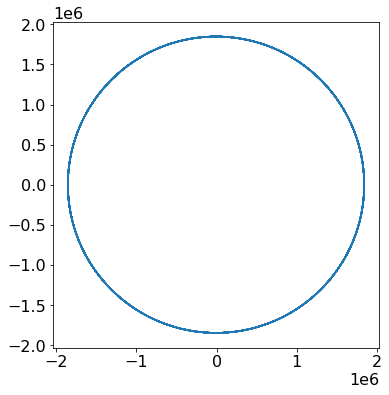

In [6]:
fig = plt.plot(x_pos,y_pos)
plt.gca().set_aspect('equal', adjustable='box')

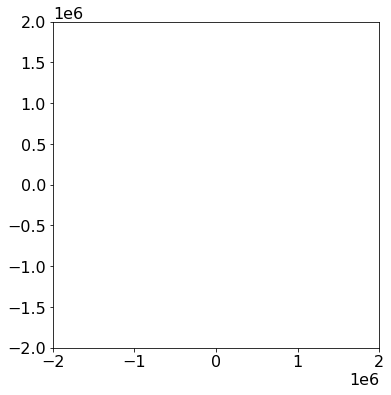

In [7]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim(-2e6, 2e6)
ax.set_ylim(-2e6, 2e6)
line, = ax.plot([], [], lw=2)
plt.gca().set_aspect('equal', adjustable='box')

In [8]:
# initialization function
def init():
    line.set_data([], [])
    return (line,)

# animation function. This will be call in a sequence to generate frames.
def animate(i):
    start = max(0,i-5)
    line.set_data(x_pos[start:i], y_pos[start:i])
    return (line,)

In [9]:
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=day/n_points, blit=True)

HTML(anim.to_jshtml())

# Task 2 (15p)

Determine the orbital period T. Your solution must be calculated numerically, i.e., not simply using the analytical expression. The obtained value must be within +/-1 s of the correct value.

In the cell below, write a function that returns the orbital period in units of seconds.

In [10]:
import scipy
from scipy import interpolate
import scipy.interpolate as spi
from scipy import optimize
from scipy.interpolate import interp1d

In [11]:
'''
find points where y_pos changes sign and obtain corresponding times
changes in sign occurs because there is a change in quadrants, so that will be an 
indicator for period
'''
t = np.linspace(0, t_max, n_points)

def findchanges(var1,var2):
# finds positions where there is a change in sign when 2 variables are plotted
    
    count = 0                     # count iterations to identify index of position where change happens
    
    for index, (i,j) in enumerate(zip(var1,var2)):
        
        if var1[index-1] * var1[index] < 0:          # change of sign occurs
            count += 1

            if count == 2:              
            # second change of sign means changes side in one of the axes hence one period complete
                #coordinates where change occurred:
                coord1 = var1[index]
                coord2 = var1[index - 1]
                
                
                time1 = var2[index]
                time2 = var2[index - 1]
                
                timeapprox = var2[index]
                return [coord1, coord2, time1, time2, index-1, index]

In [12]:
#interpolation function
def interpolation(var1, var2):
    f = spi.interp1d(var1, var2, kind='linear',axis=0, fill_value="extrapolate")
    return f

In [13]:
#use brent method to find root
def brentq(func, a, b):
    root = scipy.optimize.brentq(func, a, b, rtol=0.001, maxiter=100)
    return root

In [14]:
def task2():
    
    coords = findchanges(y_pos,t)
    time1, time2 = coords[2],coords[3]          #time increment between the two position coordinates
    
    f = interpolation(t,y_pos)                  #interpolation between two coordinated to obtain time
    period = brentq(f, time1, time2)            #brent method calculates a root for the function (period)
    
    return period
print(task2())

7138.40832320145


## Testing task 2

The cell below will run your function and compare with the analytic answer. They should agree to within 1 second.

In [15]:
T_calc = task2()
t1 = time.time()
print (f"Calculated orbital period: {T_calc} seconds.")
t2 = time.time()

mu = gg * mass
T_analytic = 2 * np.pi * np.sqrt((rs[0]**3 * mu**2) / (2*mu - rs[0]*vs[1]**2)**3)

print (f"Difference with correct answer: {T_calc - T_analytic} seconds.")
print (f"Solution calculated in {t2-t1} seconds.")

assert abs(T_calc - T_analytic) <= 1

print ("Hooray!")

Calculated orbital period: 7138.40832320145 seconds.
Difference with correct answer: 0.008898413160750351 seconds.
Solution calculated in 0.000400543212890625 seconds.
Hooray!


# Task 3 (20p)

Now add a correction that makes the gravitational field non-spherical. The correction rotates with the Moon (one full rotation every T$_{Moon}$ = 27.3 days). How long does it take until the spacecraft hits the Moon? The time must be accurate to +/-1 s. Assume the Moon’s surface is a sphere. The equations of motion now become:

$
\Large
\begin{align}
\frac{d^{2} x}{dt^2} = - \frac{G M x}{(x^2 + y^2)^{3/2}}
- \frac{q\ G M x^\prime}{(x^{^\prime2} + y^{^\prime2})^{3/2}}
\end{align}
$

$
\Large
\begin{align}
\frac{d^{2} y}{dt^2} = - \frac{G M y}{(x^2 + y^2)^{3/2}}
- \frac{q\ G M y^\prime}{(x^{^\prime2} + y^{^\prime2})^{3/2}}
\end{align}
$

$
\Large
\begin{align}
x^\prime = x + 0.8\ R \cos \left( \frac{2 \pi t}{T_{Moon}} \right)
\end{align}
$

$
\Large
\begin{align}
y^\prime = y + 0.8\ R \sin \left( \frac{2 \pi t}{T_{Moon}} \right)
\end{align}
$

where q = 0.00025.

## Task 3 objectives:
1. Compute the time at which the spacecraft hits the Moon.
2. Make a plot of the height of the spacecraft above the Moon's surface as a function of time. Don't forget to label axes and include units.

# Task 3 part 1

In the cell below, create a function that returns the impact time accurate to within 1 second.

In [90]:
import math
import numpy as np

In [91]:
T_moon = 27.3 * day

In [92]:
def func3(start, t):
    #function to return derivatives
    R = radius    
    q = 0.00025
    
    #state of the system at the beginning (positions and velocities)
    x, y, vx, vy = start
    
    x_prime = x + 0.8 * radius * np.cos((2 * math.pi * t)/T_moon)
    y_prime = y + 0.8 * radius * np.sin((2 * math.pi * t)/T_moon)
    
    d2x_dt2 = -((gg * mass * x)/(x**2 + y**2)**(3/2)) -((q * gg * mass * x_prime)/(x_prime**2 + y_prime**2)**(3/2))
    d2y_dt2 = -((gg * mass * y)/(x**2 + y**2)**(3/2)) -((q * gg * mass * y_prime)/(x_prime**2 + y_prime**2)**(3/2))
    
    derivs = vx, vy, d2x_dt2, d2y_dt2
    
    return derivs

In [93]:
def integrate():
#integrates above derivatives over time range
    
    t = np.linspace(0, T_moon, 40000)
    
    x0, y0, vx0, vy0 = rs[0], rs[1], vs[0], vs[1]
    a = x0, y0, vx0, vy0
    
    psoln = odeint(func3, a, t)
    x, y = psoln[:,0], psoln[:,1]

    return x, y, t

In [94]:
def impacttime(x_positions, y_positions, time, radius_impact):
#calculates impact time

    count = 0
    
    #iterate coordinates as time goes by
    for index, (i,j,k) in enumerate(zip(x_positions, y_positions, time)):
        #calculate radius of orbit
        r = math.sqrt(x_positions[index]**2 + y_positions[index]**2) 
        if r > radius_impact:
            count += 1
        if r <= radius_impact: 
            break
            
    return time[count]

## Testing task 3 part 1

The cell below will run your function and print your answer. This will be tested against the correct answer (not given).

In [95]:
def task3(): 
    x, y, t = integrate()
    impact = impacttime(x, y, t, radius)
    return impact

In [96]:
t1 = time.time()
t_impact = task3()
t2 = time.time()

print (f"Time to impact: {t_impact:.2f} seconds ({t_impact / day:.2f} days).")
print (f"Solution calculated in {t2-t1} seconds.")
### BEGIN HIDDEN TESTS
t_correct = 627064.2858659648

print (f"Difference with correct answer: {t_impact - t_correct} seconds.")

assert abs(t_impact - t_correct) <= 1
### END HIDDEN TESTS

Time to impact: 627081.39 seconds (7.26 days).
Solution calculated in 0.836585521697998 seconds.
Difference with correct answer: 17.10316876100842 seconds.


AssertionError: 

## Task 3 part 2

In the cell below, plot of the height of the spacecraft above the Moon's surface as a function of time. Don't forget to label axes and include units.

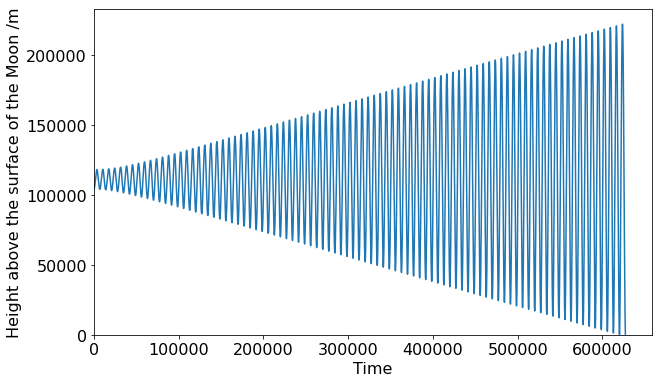

In [52]:
#height is orbital radius - moon radius

def height():
    x, y, t = integrate()
    
    #create empty array for height values
    heights = np.zeros(len(x))

    for index, (i,j,k) in enumerate(zip(x, y, heights)):
        
        #calculate height for speficic position
        heights[index] = np.sqrt(x[index]**2 + y[index]**2) - radius
        
        if heights[index] > 0:              #spacecraft is still above the moon's surface
            index += 1
            
        elif heights[index] <= 0:           #spacecraft collides with moon's surface
            break
            return index

    #trim arrays up to impact time
    t = t[:index]
    heights = heights[:index]
    
    plt.plot(t,heights)
    plt.xlabel('Time')
    plt.ylabel('Height above the surface of the Moon /m')
    plt.ylim(0)
    plt.xlim(0)
    plt.show()

height()

# Task 4 (10p)

Which coordinate (x or y) of the position of the spacecraft after one revolution (orbital period T from task 2) is more sensitive to small changes in the amplitude of the correction? To answer this, calculate the derivatives of dx/dq and dy/dq at t = T, for q = 0. Write your answer in the cell below, describing how you arrived at it. Place any code that demonstrates your solution in the cell with the function called `task4`.

In [53]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [54]:
T = task2()            #period value calculated in task 2

def func4(start, t, q):   #function for derivatives with q as an argument as it is now variable  
    R = radius
    
    x, y, vx, vy = start
    
    x_prime = x + 0.8 * radius * np.cos((2 * math.pi * t)/T_moon)
    y_prime = y + 0.8 * radius * np.sin((2 * math.pi * t)/T_moon)
    
    d2x_dt2 = -((gg * mass * x)/(x**2 + y**2)**(3/2)) - ((q * gg * mass * x_prime)/(x_prime**2 + y_prime**2)**(3/2))
    d2y_dt2 = -((gg * mass * y)/(x**2 + y**2)**(3/2)) - ((q * gg * mass * y_prime)/(x_prime**2 + y_prime**2)**(3/2))
    
    derivs = vx, vy, d2x_dt2, d2y_dt2
    
    return derivs

In [55]:
def task4(q):
    
    t = np.linspace(0, T, 200)
    
    #initial values of positions and velocities of x and y components
    x0, y0, vx0, vy0 = rs[0], rs[1], vs[0], vs[1]
    
    initial_state = x0, y0, vx0, vy0
        
    #call the ODE solver
    soln = odeint(func4, initial_state, t, args=(q,))
    
    #group x and y positions
    x = soln[:,0]
    y = soln[:,1]
    
    return (x[-1], y[-1])

In [56]:
#function to evaluate positions at different values of q
def evaluate(q):
    
    x_values = np.zeros(len(q))
    y_values = np.zeros(len(q))
    
    for i in range(len(q)):
        x, y = task4(q[i])
        derivx = np.array(x)
        derivy = np.array(y)
        x_values[i] = derivx
        y_values[i] = derivy
    
    return x_values, y_values

In [57]:
# function to plot the dx/dq against dy/dq
def plot_derivatives(q):

    x_values, y_values = evaluate(q)

    # plot a graph to obtain a visual reference to confirm the result
    x_plot = plt.plot(q,x_values, label="dx/dq values")
    y_plot = plt.plot(q,y_values, label="dy/dq values")
    
    plt.xlabel('q')
    plt.legend()
    plt.grid()

    plt.show()

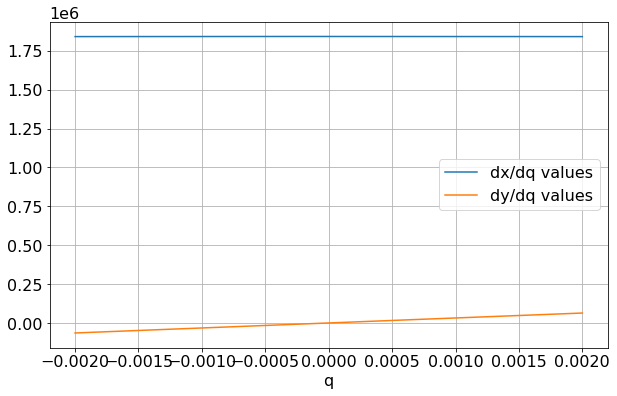

dy/dq is greater than dx/dq at q = 0


In [58]:
#compare the two derivatives to determine sensitivity
def comparison():
    q = np.linspace(-0.002, 0.002, 200)
    x_values, y_values = evaluate(q)
    
    plot_derivatives(q)
    
    #interpolate to get function expression for derivatives
    funcx = spi.interp1d(q, x_values, axis=0, fill_value="extrapolate")
    funcy = spi.interp1d(q, y_values, axis=0, fill_value="extrapolate")

    
    #since we do not have the derivative we can crudely approximate it by finite differences
    #secant method below approximates the two derivatives close to q = 0
    dxdq = scipy.optimize.newton(funcx, -0.2496, fprime=None, args=(), tol=1e-08, maxiter=200, fprime2=None, x1=-0.2494, rtol=1e-08)
    dydq = scipy.optimize.newton(funcy, -0.0001, fprime=None, args=(), tol=1e-08, maxiter=200, fprime2=None, x1= 0.0001, rtol=1e-08)
        
    if dxdq > dydq:
        print('dx/dq is greater than dy/dq at q = 0')
        
    elif dxdq < dydq:
        print('dy/dq is greater than dx/dq at q = 0')
        
    else:
        print('dy/dq = dx/dq and so no conclusion can be made')
        
comparison()

The y-coordinate of the position is more sensitive to small changes as dy/dq is greater than dx/dq at q = 0. This means that small changes in q will cause larger changes in the y-coordinate than the x-coordinate, since the gradient is the rate of change of the variable itself.

# Task 5 (10p)

The positions of the spacecraft at t=0, t=T/2, and t=T are given in the cell below. Use them to determine the amplitude of the correction q. Note, this is a different value than for the previous tasks.

A comment for those interested in space science: this is a highly simplified and unrealistic version of the task NASA scientists had to carry out to map out the gravity at the Moon's surface using "telemetry" data (positions and velocities) of various spacecrafts orbiting the Moon.

Put your code in the cell that starts with `def task5():`.

Your answer should be within 20% of the correct answer.

In [59]:
from scipy.optimize import minimize_scalar

In [60]:
r1 = [1842280.0, 0.0]
r2 = [-1856332.7223839264, -717.5195460640389]
r3 = [1842271.070055315, 3847.378923359429]

In [61]:
#function that returns derivatives
def func5(initial_conditions, t, q):     

    x, y, vx, vy = initial_conditions        
    
    x_prime = x + 0.8 * radius * np.cos((2 * np.pi * t)/T_moon)
    y_prime = y + 0.8 * radius * np.sin((2 * np.pi * t)/T_moon)
    
    d2x_dt2 = -((gg * mass * x)/(x**2 + y**2)**(3/2)) -((q * gg * mass * x_prime)/(x_prime**2 + y_prime**2)**(3/2))
    d2y_dt2 = -((gg * mass * y)/(x**2 + y**2)**(3/2)) -((q * gg * mass * y_prime)/(x_prime**2 + y_prime**2)**(3/2))
 
    derivs = vx, vy, d2x_dt2, d2y_dt2 
    return derivs 

In [62]:
def trajectories(q, t):
#returns the positions of the spacecraft at times T and T/2
    
    #initial values of each variable in the 4-variable tuple
    x0, y0, vx0, vy0 = rs[0], rs[1], vs[0], vs[1]
 
    #tuple for the initial state of the system
    initial_state = x0, y0, vx0, vy0
 
    #integrate for range of time values
    trajectory = odeint(func5, initial_state, t, args=(q,))
    x_trajectory = trajectory[:,0]
    y_trajectory = trajectory[:,1]
 
    #we calculate the position in the time array where t = T/2
    half_T_x = int(len(t)/2)-1
    half_T_y = int(len(t)/2)-1
 
    return(x_trajectory[half_T_x], y_trajectory[half_T_y], x_trajectory[-1], y_trajectory[-1]) 

In [63]:
def group_trajectories(q):                   #returns trajectories for different values of q at t = 0, T, T/2

    t = np.linspace(0,T_moon,200)
    
    #create empty arrays for x and y trajectories at each t
    x_T = np.zeros(len(q))
    y_T = np.zeros(len(q))
    x_halfT = np.zeros(len(q))
    y_halfT = np.zeros(len(q))  
    
    for i ,j in enumerate(q):
        #call positions for q and t
        components = trajectories(j, t)
 
        #populate x and y arrays as functions of q
        x_halfT[i] = components[0]
        y_halfT[i] = components[1]
        x_T[i] = components[2]
        y_T[i] = components[3]  
        
    #return the trajectories of x and y for different q values for t=0, t=T and t=T/2
    return x_T, y_T, x_halfT, y_halfT

In [70]:
def task5():
     
    #calculates amplitude of the correction q using given positions at t=0, t=T/2, and t=T 
 
    #positions at t = 0 are identical in given values and calculated ones, thus 
    #there will be no difference between calculated and given posiitons
 
    #returns best q value 
    
    q_trials = np.linspace(0.0001,0.0003,800)
    # Actual positions (given):
    # @ t = T/2
    x_actual_halfT = r2[0] 
    y_actual_halfT = r2[1]
    # @ t = T
    x_actual_T = r3[0]     
    y_actual_T = r3[1]
 
    #Calculated Positions
    x_calc_T, y_calc_T, x_calc_halfT, y_calc_halfT = np.array(group_trajectories(q_trials))
 
    #calculates the difference between the calculated and given values of the positions
    diff_x_halfT = abs(x_actual_halfT - x_calc_halfT)
    diff_y_halfT = abs(y_actual_halfT - y_calc_halfT)

    diff_x_T = abs(x_calc_T - x_actual_T)
    diff_y_T = abs(y_calc_T - y_actual_T)
 
    #takes the corresponding index of the minimum of the calculated differences
    index_x_halfT = np.argmin(diff_x_halfT)
    index_y_halfT = np.argmin(diff_y_halfT)
    index_x_T = np.argmin(diff_x_T)
    index_y_T = np.argmin(diff_y_T)
    
    #choose the value that yields the smallest difference between actual and calculated positions
    choice = min(index_x_halfT, index_y_halfT, index_x_T, index_y_T)
    
    q_value = q_trials[choice]
    return(q_value)
 
task5()

15 26 26 8


8.999999999999998e-05

## Testing task 5

The cell below will run your function and print your answer. This will be tested against the correct answer (not given). Your answer should be within 20% of the correct answer.

In [71]:
t1 = time.time()
mystery_q = task5()
t2 = time.time()

print (f"q = {mystery_q}")
print (f"Solution calculated in {t2-t1} seconds.")

### BEGIN HIDDEN TESTS
q_correct = 0.00012

print (f"Difference with correct answer: {100*abs(mystery_q/q_correct-1)}%.")

assert abs(mystery_q/q_correct-1) <= 0.2
### END HIDDEN TESTS

15 26 26 8
q = 8.999999999999998e-05
Solution calculated in 22.324376106262207 seconds.
Difference with correct answer: 25.00000000000002%.


AssertionError: 

# Task 6 (15p)

What is the minimum initial height of a circular orbit such that, for the perturbation from task 3 (q = 0.00025), the spacecraft does not collide with the Moon but remains gravitationally bound to it?

The orbit may still show oscillations as in task 3, but the spacecraft cannot not hit the lunar surface.

Create a function `task6` that returns the minimum height of the circular orbit in units of meters. Explain your approach. To obtain full marks, the answer must be correct to +/-1 km.

The following formula for the velocity of a point mass in circular orbit of radius r, orbiting a spherically symmetric body of mass M, may be useful:

$
\Large
\begin{align}
v_{c} = \sqrt{\frac{G\ M}{r}}.
\end{align}
$

In the cell below, create a function that calculates the minimum height of a stable orbit in units of meters. Your answer should be within 1000 meters of the correct answer.

In [72]:
'''
This task may not give the correct output because of some errors
What we need:

1) calculate vc at any position
2) integrate vc and calculate orbital radius for every position
3) calculation of impact time
4) calculation of impact time for VARYING initial height (i.e. vary initial x position)
5) satellite remains in orbit if maximum number of steps done before impact is equal to length of list 
of coordinates at that specific height
6) use brent method to find minimum initial height 
===========================================================================

tol = 1e03
'''

'\nThis task may not give the correct output because of some errors\nWhat we need:\n\n1) calculate vc at any position\n2) integrate vc and calculate orbital radius for every position\n3) calculation of impact time\n4) calculation of impact time for VARYING initial height (i.e. vary initial x position)\n5) satellite remains in orbit if maximum number of steps done before impact is equal to length of list \nof coordinates at that specific height\n6) use brent method to find minimum initial height \n===========================================================================\n\ntol = 1e03\n'

In [73]:
def v_circular(r):
        
    return math.sqrt(gg * mass/ r)

In [74]:
def orbital_path(t, r_initial):
    #find cartesian coordinates
    q = 0.00025
    
    #initial values of 
    x0, y0, vx0, vy0 = r_initial, rs[1], vs[0], vs[1]
    
    initial_state = x0, y0, vx0, vy0
    initial_radius = math.sqrt(x0**2 + y0**2)
        
    #call the ODE solver
    cartesian = odeint(func4, initial_state, t, args=(q,))
    
    #group x and y positions
    x = cartesian[:,0]
    y = cartesian[:,1]
    
    orbital_radii = np.concatenate((np.array([initial_radius]),np.zeros(len(t))))
    
    #define radius
    for index, (i, j) in enumerate(zip(x, y)):
        radius = math.sqrt(i**2 + j**2)
        orbital_radii[index] = radius

    return np.array([orbital_radii])

In [75]:
def varyR(r_trials):
    t = np.linspace(0, T_moon, 200)
    radius = 1738000
    
    radii = []
    for i in range(len(r_trials)):
        orbit = np.array([orbital_path(t, r_trials[i])])
        radii.append(r_trials[i])
        
        #if len(orbit[orbit > radius]) == len(t):          
         #   heights.append(r_trials[i])
    
    return radii

In [88]:
def task6():
    '''
    this function should be able to calculate the point where minimum stable height occurs, 
    then obtain the height which would cause circular velocity to be less than 0 and take those
    two values to perform the brentq method and return minimum height
    '''
    
    r_trials = np.linspace(1e7,1e5,100)       #range of radii to try
    
    radii = varyR(r_trials)
    
    heights = []
    heights_above = []
    indexes_below = []
    
    for i in range(len(radii)):
        heights.append(radii[i]-radius)
        if np.any(radii[i]) > radius:               #omit radii that show the craft crashes 
            indexes_below.append(i)  
            break
        return i
    height_below = i
    heights_above = heights[heights > radius]
    
    minimum_height_calculated = min(heights_above)
    
    #find root near v_c = 0 and through brentq method    
    height = scipy.optimize.brentq(v_circular, minimum_height_calculated, height_below, xtol=2e-12)
    
    return height
print(task6())

0


## Testing task 6

The cell below will run your function and print your answer. This will be tested against the correct answer (not given). Your answer should be within 1000 meters of the correct answer.

In [89]:
t1 = time.time()
min_height = task6()
t2 = time.time()
print (f"Minimum height of stable orbit: {min_height} m.")
print (f"Solution calculated in {t2-t1} seconds.")

### BEGIN HIDDEN TESTS
min_height_correct = 154047.6006164552

print (f"Difference with correct answer: {min_height - min_height_correct} meters.")

assert abs(min_height - min_height_correct) <= 1000
### END HIDDEN TESTS

Minimum height of stable orbit: 0 m.
Solution calculated in 5.998147487640381 seconds.
Difference with correct answer: -154047.6006164552 meters.


AssertionError: 